In [1]:
import prop
import pandas as pd
import matplotlib.pyplot as plt
from modules import pump, regen, heater, turbine, condenser

#Таблица с потоками и блоками:
streams = pd.read_excel("streams.xlsx",index_col=0)
blocks  = pd.read_excel("blocks.xlsx" ,index_col=0)

#Параметры нагревающей среды:
gas  = 'REFPROP::N2[0.78]&O2[0.1]&CO2[0.02]&H2O[0.1]'                      #Состав газа
Tin  = 183.6                                                               #Температура газов на входе
Pgas = 0.1                                                                 #Давление газов
Ggas = 509                                                                 #Расход газов
Tout = 80                                                                  #Температура газов на выходе

#Параметры охлаждающей среды:
fluidcond  = "REFPROP::WATER" #Охлаждающая среда
Tfluidcond = 15               #Температура охл. среды
Pfluidcond = 0.5              #Давление охл. среды

#Параметры ОЦР:
fluid   = "REFPROP::R236ea"   #Рабочая среда цикла
Ppump   = 3.3                 #Давление на выходе из насоса
KPDpump = 0.8                 #КПД насоса
KPDturb = 0.85                 #КПД турбины
DTheat  = 20                  #Минимальный напор в нагревателе
DTcond  = 5                   #Минимальный напор в конденсаторе
Pcond   = prop.t_q(30,0,fluid)['P']               #Давление в конденсаторе

#Первое приближение


dTreg   = 5                   #Минимальный напор в регенераторе
dPreg1  = 0                #Потери по горячему в МПа
dPreg2  = 0                 #Потери по холодному

streams = pd.read_excel("streams.xlsx",index_col=0)
blocks  = pd.read_excel("blocks.xlsx" ,index_col=0)


#Внесение входных данных в таблицу:
streams.loc["IN-HEAT", "T":"Q"] = [Tin,Pgas,prop.t_p(Tin,Pgas,gas)["H"],prop.t_p(Tin,Pgas,gas)["S"],Ggas,1]
streams.loc["IN-COND", "T":"Q"] = [Tfluidcond,Pfluidcond,prop.t_p(Tfluidcond,Pfluidcond,fluidcond)["H"],prop.t_p(Tfluidcond,Pfluidcond,fluidcond)["S"],300,0]

#Начало расчёта - задание расхода на первой итерации:
G = Ggas*(prop.t_p(Tin,Pgas,gas)["H"]-prop.t_p(Tout,Pgas,gas)["H"])/(prop.t_p(Tin,Ppump,fluid)["H"]-prop.t_p(Tout,Ppump,fluid)["H"])

#Поток перед насосом:
streams.loc["COND-PUMP", "T":"Q"] = [prop.p_q(Pcond,0,fluid)["T"],Pcond,prop.p_q(Pcond,0,fluid)['H'],prop.p_q(Pcond,0,fluid)['S'],G,0]

#Итеративный расчет для сведения баланса:
for i in range(100):
    #Расчет цикла:
    pump.calc     ("COND-PUMP", "PUMP-REG",                          Ppump,  KPDpump,     fluid, streams, blocks)
    regen.calc    ("TURB-REG",  "REG-COND",  "PUMP-REG","REG-HEAT",  dTreg, dPreg1,dPreg2,fluid, streams, blocks)
    heater.calc   ("IN-HEAT",   "HEAT-OUT",  "REG-HEAT","HEAT-TURB", Tout,   DTheat, gas, fluid, streams, blocks)
    turbine.calc  ("HEAT-TURB", "TURB-REG",                          Pcond+dPreg1,  KPDturb,fluid, streams, blocks)
    regen.calc    ("TURB-REG",  "REG-COND",  "PUMP-REG","REG-HEAT",  dTreg, dPreg1,dPreg2,fluid, streams, blocks)
    condenser.calc("REG-COND",  "COND-PUMP", "IN-COND" ,"COND-OUT",  DTcond, fluidcond,   fluid, streams, blocks)
    Qbalance = blocks.loc['HEATER','Q']+blocks.loc['PUMP','N']-blocks.loc['CONDENSER','Q']-blocks.loc['TURBINE','N']
    print (Qbalance)
    if abs(Qbalance) < 1: #Макс погрешность 1 кВт
        break


KPD = (blocks.loc['TURBINE','N']-blocks.loc['PUMP','N'])/blocks.loc['HEATER','Q']
print (round(KPD,5))




5384.113519088547
-3240.734788491174
1603.1835660830275
-899.8194833776706
473.50143223055966
-258.54497163612723
138.15592610447493
-74.52249153134107
39.96664044885256
-21.501012091213852
11.547766786003194
-6.207637053792496
3.3353836397054692
-1.7925750182221236
0.9632711737522186
0.15784


In [2]:
streams

,T,P,H,S,G,Q
IN-HEAT,183.600000,0.100000,628.266954,7.349244,509.000000,1.0
HEAT-OUT,80.000000,0.100000,515.655043,7.069707,509.000000,1.0
COND-PUMP,30.000000,0.244324,237.395788,1.129466,302.870678,0.0
PUMP-REG,32.122439,4.300000,240.975136,1.131813,302.883226,0.0
REG-HEAT,39.454349,4.300000,250.206780,1.161696,302.883226,0.0
HEAT-TURB,153.390991,4.300000,439.459259,1.665945,302.870678,1.0
TURB-REG,47.188243,0.244324,406.089168,1.684514,302.870678,1.0
REG-COND,37.122439,0.244324,396.857140,1.655233,302.870678,1.0
IN-COND,15.000000,0.500000,63.458441,0.224388,1039.104333,0.0
COND-OUT,26.111939,0.500000,109.937092,0.382657,1039.104333,0.0


In [3]:
blocks

,N,Q,COST
PUMP,1084.124274,NaN,NaN
TURBINE,10106.822362,NaN,NaN
REGENERATOR,NaN,2796.110307,NaN
CONDENSER,NaN,48296.167790,NaN
HEATER,NaN,57319.463017,NaN


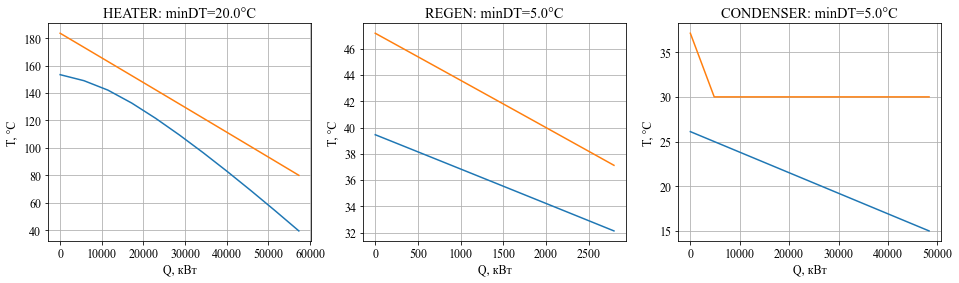

In [4]:
#Вывод T-Q:
plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
heater.TQ("IN-HEAT","HEAT-OUT","REG-HEAT","HEAT-TURB",gas,fluid,streams)
plt.subplot(1, 3, 2)
regen.TQ("TURB-REG","REG-COND","PUMP-REG","REG-HEAT",fluid,streams)
plt.subplot(1, 3, 3)
condenser.TQ("REG-COND","COND-PUMP","IN-COND","COND-OUT",fluidcond,fluid,streams)
plt.show()